## **Задача.** Построить математическую модель стоимости жилья в зависимости от параметров этого жилья.

### **Постановка задачи**:
**Цель:** Построить математическую модель стоимости жилья в зависимости от параметров этого жилья.

**Источник данных:** www.citystar.ru

**Целевой признак:** *Price* — стоимость жилья (тыс.руб.)

**Метрика оценки качества:** *RMSE*.


### **Описание проекта:**
- Источник исходных данных www.citystar.ru - сайт магнитогорской недвижимости.
- парсила данные с помощью Web Scraper.

**Исходные данные:**
- `type_flat` - тип квартиры
- `region` - регион
- `adress` - адрес
- `floor` - этаж
- `s_total_m2` - общая площадь
- `s_live_m2` - жилая площадь
- `s_kitchen_m2` - площадь кухни
- `descr` - описание
- `price_ti_rub` - стоимость в тыс.руб.

**Алгоритм решения:**
  1. Скачать данные с сайта (выбрать метод, реализовать).
  2. Загрузка данных.
   - Предварительное изучение данных.
   - Отчистка от явно лишней информации.
   - Формирование общего датасета для дальнейшего исследование и предобработки.
  3. Предобработка данных:
    - Работа с аномалиями, пропусками и дубликатами.
    - формирования датасета для анализа.
  4. Анализ данных и подготовка для построения математической модели:
    - Непосредственно анализ.
    - Удаление неинформативных признаков, генерация ряда признаков, по необходимости.
    - Разделение общего датасета на выборки для обучения и проверки модели.
    - Кодирование и масштабирование признаков - стандартизация данных, по необходимости.
  5. Построение и обучение математической модели:
    - описание моделей
    - Предварительная проверка моделей
    - Линейная регрессия,Ridge.
    - Light GBMRegressor,
    - CatBoostRegressor,
    - XGBRegressor.
  6. Выбор лучшей модели. Тестирование.
  7. Выводы.

## **1. Скачать данные с сайта (выбрать метод, реализовать)**
- Источник исходных данных www.citystar.ru - сайт магнитогорской недвижимости.
- парсила данные с помощью **`Web Scraper`**:
 - Взяла информацию в 300 позиций, структура сайта такова, что идет вывод по 100 позиций на страницу, постраничный парсинг данным методом не реализуется, поэтогму по итогу получила 3 файла (`flat1.csv`, `flat2.csv`, `flat3.csv`) с данными по 100 позиций в формате `csv`.

 данные можно скачать [здесь](https://drive.google.com/drive/folders/1zcl5_UfQzTnyB3JNv8tgNFte_sEPFfpC?usp=drive_link)
  > тестила метод с помощью кода на **python**, но здесь надо дольше разбираться, поэтому решила воспользоваться расширением **`Web Scraper`**.


## **2. Загрузка данных.**

Предварительное изучение данных. Отчистка от явно лишней информации. Формирование общего датасета для дальнейшего исследование и предобработки.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump
import math
import time
import re
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, mean_absolute_error,  mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from numpy.random import RandomState
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import Ridge, LinearRegression
from xgboost import XGBRegressor

#проект запускаю в colab
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    !pip install catboost
    !pip install ipywidgets
    !jupyter nbextension enable --py widgetsnbextension

    print('Environment: Google Colab')

!"{sys.executable}" -m pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report
from catboost import CatBoostRegressor

In [2]:
#если данные храняться на googledisk, подключаем его
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import warnings
warnings.filterwarnings('ignore')
try:
    data1=pd.read_csv('/content/drive/MyDrive/TEST/Белка Диджитал/data/flat1.csv')
    data2=pd.read_csv('/content/drive/MyDrive/TEST/Белка Диджитал/data/flat3.csv')
    data3=pd.read_csv('/content/drive/MyDrive/TEST/Белка Диджитал/data/flat5.csv')
except:
    data1=pd.read_csv('/content/flat1.csv')
    data2=pd.read_csv('/content/flat3.csv')
    data3=pd.read_csv('/content/flat5.csv')

### **Предварительное изучение данных.**

In [4]:
# Приведем все даенные в читаемый формат
#pd.options.display.float_format = '{:,.1f}'.format
def express_info(data, name):
    print(f'Информация {name}:')
    data.info()
    display(data.head(3))
    print()

In [5]:
express_info(data1, '1 датасета (первые 100 позиций)')
express_info(data2, '2 датасета (вторые 100 позиций)')
express_info(data3, '3 датасета (третьи 100 позиций)')

Информация 1 датасета (первые 100 позиций):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   web-scraper-order      103 non-null    object 
 1   web-scraper-start-url  103 non-null    object 
 2   page1                  0 non-null      float64
 3   page1-href             0 non-null      float64
 4   photo                  4 non-null      object 
 5   date                   101 non-null    object 
 6   type_flat              100 non-null    object 
 7   region                 63 non-null     object 
 8   adress                 99 non-null     object 
 9   floor                  100 non-null    object 
 10  s_total_m2             100 non-null    float64
 11  s_live_m2              100 non-null    float64
 12  s_kitchen_m2           100 non-null    float64
 13  descr                  98 non-null     object 
 14  price_ti_rub  

,web-scraper-order,web-scraper-start-url,page1,page1-href,photo,date,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub,phone
0,1690479972-1,http://citystar.ru/detal.htm?d=43&nm=%CE%E1%FA...,NaN,NaN,о,ж,к,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1690479972-2,http://citystar.ru/detal.htm?d=43&nm=%CE%E1%FA...,NaN,NaN,NaN,27.07\n21:35,Трехкомнатная свердловский вариант,Орджоникидзевский,Калмыкова 12,9/9,64.0,40.0,10.0,Описание\n КВАРТИРА С ОТЛИЧНЫМ КАПИТАЛЬНЫМ РЕМ...,4390.0,89128051254 ... Байгузина Юлия Владимировна
2,1690479972-3,http://citystar.ru/detal.htm?d=43&nm=%CE%E1%FA...,NaN,NaN,NaN,27.07\n19:32,Двухкомнатная брежневка,Ленинский,Тарасенко 6,5/5,45.0,29.0,6.0,Продам двухкомнатную квартиру в среднем состоя...,1800.0,89090995415 ... Леонтьева Ольга



Информация 2 датасета (вторые 100 позиций):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   web-scraper-order      103 non-null    object 
 1   web-scraper-start-url  103 non-null    object 
 2   photo                  4 non-null      object 
 3   date                   101 non-null    object 
 4   type_flat              100 non-null    object 
 5   region                 56 non-null     object 
 6   adress                 99 non-null     object 
 7   floor                  100 non-null    object 
 8   s_total_m2             100 non-null    float64
 9   s_live_m2              100 non-null    float64
 10  s_kitchen_m2           100 non-null    float64
 11  descr                  100 non-null    object 
 12  price_ti_rub           100 non-null    float64
 13  phone                  100 non-null    object 
 14  page2        

,web-scraper-order,web-scraper-start-url,photo,date,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub,phone,page2,page2-href
0,1690480469-1,http://citystar.ru/detal.htm?d=43&nm=%CE%E1%FA...,о,ж,к,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101-200,http://citystar.ru/detal.htm?v_id=0&d=43&nm=%C...
1,1690480469-2,http://citystar.ru/detal.htm?d=43&nm=%CE%E1%FA...,NaN,18.07\n08:33,Двухкомнатная,NaN,Уральская 37,2/3,51.0,32.0,8.0,"id:5752. \nПродам замечательную, большую 2к кв...",3300.0,79049763467 ... Татьяна Казанцева,101-200,http://citystar.ru/detal.htm?v_id=0&d=43&nm=%C...
2,1690480469-3,http://citystar.ru/detal.htm?d=43&nm=%CE%E1%FA...,NaN,18.07\n08:33,Однокомнатная,NaN,ул Помяловского 7,2/5,31.0,16.0,6.0,"id:5740. \nХорошая цена отличной, светлой 1- к...",2150.0,79030916593 ... Олеся Тюкенеева,101-200,http://citystar.ru/detal.htm?v_id=0&d=43&nm=%C...



Информация 3 датасета (третьи 100 позиций):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   web-scraper-order      103 non-null    object 
 1   web-scraper-start-url  103 non-null    object 
 2   page3                  103 non-null    object 
 3   page3-href             103 non-null    object 
 4   photo                  8 non-null      object 
 5   date                   101 non-null    object 
 6   type_flat              100 non-null    object 
 7   region                 85 non-null     object 
 8   adress                 100 non-null    object 
 9   floor                  100 non-null    object 
 10  s_total_m2             100 non-null    float64
 11  s_live_m2              100 non-null    float64
 12  s_kitchen_m2           100 non-null    float64
 13  descr                  99 non-null     object 
 14  price_ti_rub 

,web-scraper-order,web-scraper-start-url,page3,page3-href,photo,date,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub,phone
0,1690482757-1,http://citystar.ru/detal.htm?d=43&nm=%CE%E1%FA...,>>>,http://citystar.ru/detal.htm?d=43&nm=%CE%E1%FA...,о,ж,к,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1690482757-2,http://citystar.ru/detal.htm?d=43&nm=%CE%E1%FA...,>>>,http://citystar.ru/detal.htm?d=43&nm=%CE%E1%FA...,NaN,10.07\n11:36,Однокомнатная,Правобережный,Ленина пр-т 86\2,3/5,31.9,19.0,6.0,Продам квартиру в хорошем состоянии.Очень уютн...,2000.0,+79026115412 ... Порпулова Оксана Аркадьевна
2,1690482757-3,http://citystar.ru/detal.htm?d=43&nm=%CE%E1%FA...,>>>,http://citystar.ru/detal.htm?d=43&nm=%CE%E1%FA...,NaN,21.06\n11:15,Двухкомнатная старой планировки,Ленинский,Чапаева 11,3/4,61.0,34.0,9.0,"квартира в среднем состоянии, все трубы поменя...",3600.0,83519014452 ... nadezdakrasnova1958@mail.ru


- Видим явно много неинформативной информации для нас, удалим ее:
столбцы с интернет ссылками, и непонятными символами (">>>"), лишние строки, то есть явные "шумы".
- Приведем все три датасета в единый формат, для дальнейшего соединения

### **Удаление явно лишней информации**

In [6]:
def clean_data (data):
    data = data.drop(['photo', 'web-scraper-order'], axis=1)    #
    data = data[data['date'] != 'ж']
    data = data.loc[:, ~data.apply(lambda x: x.astype(str).str.startswith("http://").any())]
    data = data.loc[:, ~data.apply(lambda x: x.astype(str).str.startswith(">>>").any())]
    data = data.loc[:, ~data.columns.str.startswith("page")]
    #удалим пустые неинформативные строки, где больше 90% пропущенных значений
    data = data[data.apply(lambda row: row.count() / len(row) >= 0.1, axis=1)]
    #data = data.dropna(thresh=data.shape[1] * 0.9)

    return data

In [7]:
data1 = clean_data (data1)
data2 = clean_data (data2)
data3 = clean_data (data3)

In [8]:
express_info(data1, '1 датасета (первые 100 позиций)')
express_info(data2, '2 датасета (вторые 100 позиций)')
express_info(data3, '3 датасета (третьи 100 позиций)')

Информация 1 датасета (первые 100 позиций):
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1 to 102
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          100 non-null    object 
 1   type_flat     99 non-null     object 
 2   region        63 non-null     object 
 3   adress        99 non-null     object 
 4   floor         100 non-null    object 
 5   s_total_m2    100 non-null    float64
 6   s_live_m2     100 non-null    float64
 7   s_kitchen_m2  100 non-null    float64
 8   descr         98 non-null     object 
 9   price_ti_rub  100 non-null    float64
 10  phone         100 non-null    object 
dtypes: float64(4), object(7)
memory usage: 9.4+ KB


,date,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub,phone
1,27.07\n21:35,Трехкомнатная свердловский вариант,Орджоникидзевский,Калмыкова 12,9/9,64.0,40.0,10.0,Описание\n КВАРТИРА С ОТЛИЧНЫМ КАПИТАЛЬНЫМ РЕМ...,4390.0,89128051254 ... Байгузина Юлия Владимировна
2,27.07\n19:32,Двухкомнатная брежневка,Ленинский,Тарасенко 6,5/5,45.0,29.0,6.0,Продам двухкомнатную квартиру в среднем состоя...,1800.0,89090995415 ... Леонтьева Ольга
4,27.07\n16:58,Однокомнатная,NaN,Грязнова 17,3/5,32.0,19.0,6.0,id:5068. \n!! Продам однокомнатную квартиру в ...,2050.0,79123260780 ... Дмитрий Казанцев



Информация 2 датасета (вторые 100 позиций):
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1 to 102
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          100 non-null    object 
 1   type_flat     99 non-null     object 
 2   region        56 non-null     object 
 3   adress        99 non-null     object 
 4   floor         100 non-null    object 
 5   s_total_m2    100 non-null    float64
 6   s_live_m2     100 non-null    float64
 7   s_kitchen_m2  100 non-null    float64
 8   descr         100 non-null    object 
 9   price_ti_rub  100 non-null    float64
 10  phone         100 non-null    object 
dtypes: float64(4), object(7)
memory usage: 9.4+ KB


,date,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub,phone
1,18.07\n08:33,Двухкомнатная,NaN,Уральская 37,2/3,51.0,32.0,8.0,"id:5752. \nПродам замечательную, большую 2к кв...",3300.0,79049763467 ... Татьяна Казанцева
2,18.07\n08:33,Однокомнатная,NaN,ул Помяловского 7,2/5,31.0,16.0,6.0,"id:5740. \nХорошая цена отличной, светлой 1- к...",2150.0,79030916593 ... Олеся Тюкенеева
4,18.07\n08:33,Двухкомнатная,NaN,Калмыкова 7,6/9,50.0,29.0,8.0,id:5734. \nПродам просторную 2-комнатную квар...,2950.0,79090998406 ... Ирина Корбут



Информация 3 датасета (третьи 100 позиций):
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1 to 102
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          100 non-null    object 
 1   type_flat     99 non-null     object 
 2   region        85 non-null     object 
 3   adress        100 non-null    object 
 4   floor         100 non-null    object 
 5   s_total_m2    100 non-null    float64
 6   s_live_m2     100 non-null    float64
 7   s_kitchen_m2  100 non-null    float64
 8   descr         99 non-null     object 
 9   price_ti_rub  100 non-null    float64
 10  phone         100 non-null    object 
dtypes: float64(4), object(7)
memory usage: 9.4+ KB


,date,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub,phone
1,10.07\n11:36,Однокомнатная,Правобережный,Ленина пр-т 86\2,3/5,31.9,19.0,6.0,Продам квартиру в хорошем состоянии.Очень уютн...,2000.0,+79026115412 ... Порпулова Оксана Аркадьевна
2,21.06\n11:15,Двухкомнатная старой планировки,Ленинский,Чапаева 11,3/4,61.0,34.0,9.0,"квартира в среднем состоянии, все трубы поменя...",3600.0,83519014452 ... nadezdakrasnova1958@mail.ru
4,18.07\n09:06,Двухкомнатная гостиничного типа,Ленинский,Карла Маркса 68,3/5,26.0,21.0,0.0,"Дом рядом с центральным рынком, в квартире одн...",1600.0,89512314452 ... nadezdakrasnova1958@mail.ru


In [9]:
data1.columns

Index(['date', 'type_flat', 'region', 'adress', 'floor', 's_total_m2',
       's_live_m2', 's_kitchen_m2', 'descr', 'price_ti_rub', 'phone'],
      dtype='object')

### **Формирование общего датасета для дальнейшего исследование и предобработки.**

In [10]:
data_total = data1[['date', 'type_flat', 'region', 'adress', 'floor', 's_total_m2', 's_live_m2', \
              's_kitchen_m2','descr', 'price_ti_rub', 'phone']]\
              .append(data2[['date', 'type_flat', 'region', 'adress', 'floor', 's_total_m2', 's_live_m2', \
                             's_kitchen_m2', 'descr', 'price_ti_rub', 'phone']])\
              .append(data3[['date', 'type_flat', 'region', 'adress', 'floor', 's_total_m2', 's_live_m2', 's_kitchen_m2', 'descr', 'price_ti_rub', 'phone']])


express_info(data_total, 'общего датасета (первые 300 позиций)')

Информация общего датасета (первые 300 позиций):
<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 1 to 102
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          300 non-null    object 
 1   type_flat     297 non-null    object 
 2   region        204 non-null    object 
 3   adress        298 non-null    object 
 4   floor         300 non-null    object 
 5   s_total_m2    300 non-null    float64
 6   s_live_m2     300 non-null    float64
 7   s_kitchen_m2  300 non-null    float64
 8   descr         297 non-null    object 
 9   price_ti_rub  300 non-null    float64
 10  phone         300 non-null    object 
dtypes: float64(4), object(7)
memory usage: 28.1+ KB


,date,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub,phone
1,27.07\n21:35,Трехкомнатная свердловский вариант,Орджоникидзевский,Калмыкова 12,9/9,64.0,40.0,10.0,Описание\n КВАРТИРА С ОТЛИЧНЫМ КАПИТАЛЬНЫМ РЕМ...,4390.0,89128051254 ... Байгузина Юлия Владимировна
2,27.07\n19:32,Двухкомнатная брежневка,Ленинский,Тарасенко 6,5/5,45.0,29.0,6.0,Продам двухкомнатную квартиру в среднем состоя...,1800.0,89090995415 ... Леонтьева Ольга
4,27.07\n16:58,Однокомнатная,NaN,Грязнова 17,3/5,32.0,19.0,6.0,id:5068. \n!! Продам однокомнатную квартиру в ...,2050.0,79123260780 ... Дмитрий Казанцев


## **3. Предобработка данных.**

In [11]:
#напишем функцию для исследования данных
def research(data, name, figsize, silent):
    print(f'Размер данных:      {data.shape}')
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')
    print(f'Наличие пропусков:           {data.isna().sum().sum()}')
    print('Пропущенные данные (в процентном соотношении):')
    print(round(data.isna().mean()*100).sort_values(ascending=False).head(13))
    #data.info()
    if not silent:
        print(f'\nПроверка структуры {name}:')
        data.hist(linewidth=2, histtype='step', figsize=figsize)
        plt.suptitle(f'Гистограмма распеределения {name}', y=0.95, fontsize=12)
        plt.show()

        print()
        #тепловая карта корреляций
        plt.figure(figsize=figsize)
        matrix = np.triu(data.corr())
        heatmap = sns.heatmap(data.corr(), annot=True, fmt='.2g',
                          mask=matrix, square=True,
                          cmap='Pastel1',  cbar=False,
                          xticklabels=True, yticklabels=True , vmin=0, vmax=1, center= 0)#'coolwarm', cmap=cmap,
        plt.suptitle(f'Тепловая карта матрицы корреляции {name}', y=0.91, fontsize=12)
        plt.show()
        print()
        display(data.describe())
#    if silent:
#        print(f'Корреляция {name}')
#        display(data.corr().round(3)\
#                .style\
#                .background_gradient(cmap='Pastel2', low= 0, high = 1, axis = 0, subset = None))
    display(data.sample(5))

Размер данных:      (300, 11)
Количество явных дубликатов: 0
Наличие пропусков:           104
Пропущенные данные (в процентном соотношении):
region          32.0
type_flat        1.0
adress           1.0
descr            1.0
date             0.0
floor            0.0
s_total_m2       0.0
s_live_m2        0.0
s_kitchen_m2     0.0
price_ti_rub     0.0
phone            0.0
dtype: float64

Проверка структуры данных о квартирах(300 позиций):


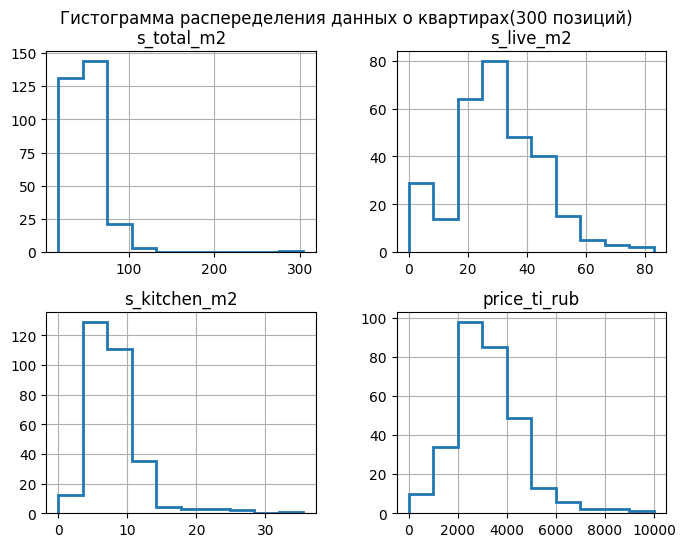

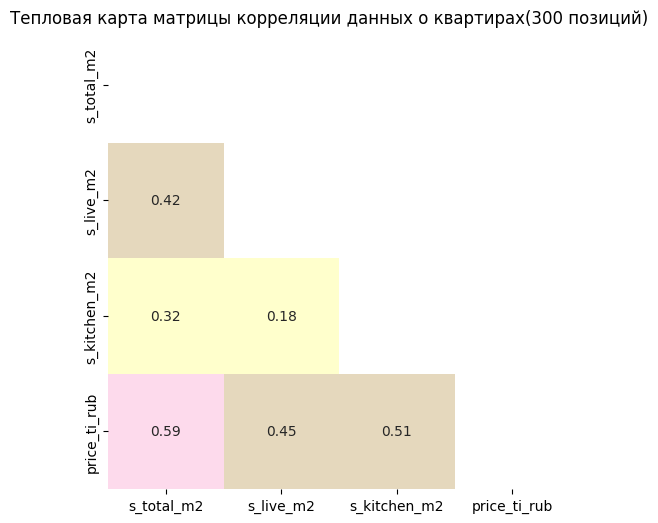

,s_total_m2,s_live_m2,s_kitchen_m2,price_ti_rub
count,300.000000,300.000000,300.000000,300.000000
mean,52.049267,29.212000,8.300933,3214.490000
std,22.993481,15.606066,3.963989,1370.906327
min,17.500000,0.000000,0.000000,0.000000
25%,39.000000,18.000000,6.000000,2287.500000
50%,49.050000,30.000000,8.000000,3095.000000
75%,62.000000,40.000000,9.000000,3955.000000
max,304.000000,83.000000,35.500000,9990.000000


,date,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub,phone
15,26.07\n12:49,Двухкомнатная,NaN,Советская 155/1,5/5,44.0,29.0,6.0,id:5056. \n!!! Продам 2-комнатную квартиру в х...,2930.0,79514596731 ... Данил Яхин
98,19.07\n15:06,Двухкомнатная,Ленинский,Комсомольская 40,1/3,48.1,29.0,6.0,Продам квартиру в спальном районе города. Инфр...,2800.0,+79090974969 ... Буйкли Юлия Анатольевна
40,24.07\n15:24,Однокомнатная,Орджоникидзевский,Бориса Ручьева 13/2,7/9,31.8,16.0,6.0,"i/iПродам большую малосемейку, в центре города...",1650.0,79193070952 ... Оксана Викторовна
11,26.07\n12:49,Двухкомнатная,NaN,ул Черемушки 13,2/2,40.0,22.0,6.0,id:5833. \nПродам двухкомнатную квартиру в п. ...,500.0,79615795998 ... Валентина Коркина
36,10.06\n11:28,Однокомнатная,NaN,Ленина пр-т 146,6/9,30.3,18.0,6.0,id:4859. \nПродам однокомнатную квартиру в Орд...,2250.0,79128050419 ... Алексей Трифонов


In [12]:
research(data_total, "данных о квартирах(300 позиций)", figsize=(8, 6), silent=False)

**Вывод:**
- явных дубликатов нет - можно удалить колонки с контактами и даты размещения, как для нас не информативные, и тогда мы увидим есть ли реально дубликаты.
- видим большое количетво пропусков 33% в колонке `region`, можно попробовать вытащить информацию из колонки "desc". в остальных случаях поставить заглушку "unknown"
- небольшой процент пропущенных данных мы видим в колонках  `type_flat`, `adress`, `descr`       -     1%. Сначала поработаем с другими колонками, потом по итогу - либо удалю, либо поставлю заглушку.
- Распределение признаков в целом нормальное, в следуущем подразделе более внимательно посотрю.
- хорошая корреляция между общей, жилой. Поэтому - при рассмотрении признаков, жилую площадь смотреть не буду, так как основным признаком буду смотреть общую, жилая коррелирует - буду удалять столбец в будущем.

### **Работа с аномалиями, пропусками и дубликатами.**

In [13]:
#current_year = pd.to_datetime('today').year
#data['date'] = pd.to_datetime(data['date'], format="%d.%m\n%H:%M").dt.strftime(f"%d.%m.{current_year}")
#переведем колонку с датой в формат даты
#data['date'] = pd.to_datetime(data['date'], format="%d.%m.%Y")
#data.sample(5)

In [14]:
data_total = data_total.drop(['date', 'phone'], axis=1)  #

In [15]:
research(data_total, "данных о квартирах(300 позиций)", figsize=(8, 6), silent=True)

Размер данных:      (300, 9)
Количество явных дубликатов: 0
Наличие пропусков:           104
Пропущенные данные (в процентном соотношении):
region          32.0
type_flat        1.0
adress           1.0
descr            1.0
floor            0.0
s_total_m2       0.0
s_live_m2        0.0
s_kitchen_m2     0.0
price_ti_rub     0.0
dtype: float64


,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub
70,Однокомнатная,Орджоникидзевский,Карла Маркса 174,6/9,31.0,17.0,6.0,"Продам квартиру в блочном доме, в центре город...",2250.0
74,Двухкомнатная,NaN,Вокзальная 2,2/2,52.0,45.0,7.0,id:4744. \n Продаётся просторная и уютная двух...,800.0
2,Двухкомнатная брежневка,Ленинский,Тарасенко 6,5/5,45.0,29.0,6.0,Продам двухкомнатную квартиру в среднем состоя...,1800.0
36,Двухкомнатная,NaN,карла маркса 5,5/5,43.0,28.0,6.2,id:4900. \nПродам квартиру. Есть ремонт: натяж...,2600.0
90,Двухкомнатная старой планировки,Ленинский,Комсомольская 38,2/3,54.1,30.0,9.0,Продаем хорошую 2-комнатную квартиру в Ленинск...,3550.0


In [16]:
def feed_size(data, state, name_state): #, x_lim0, x_lim
    print(f'Статистические данные о распределении значений {name_state} ({state}):')
    display(data[f'{state}'].describe())

    plt.subplots(figsize=(12, 1))
    #plt.xlim([x_lim0, x_lim])
    plt.title(f'Диаграмма рассеяния {name_state} ({state})')
    sns.boxplot(x=data[f'{state}'], palette='pastel', data=data[f'{state}'])
    plt.show()

    plt.figure(figsize=(12, 2))
    #sns.kdeplot(data[f'{state}'], fill=True, label=f'{state} {name_state}', alpha=0.6, shade=True)
    sns.histplot(data[f'{state}'], color="seagreen", label=f'{name_state}', alpha=0.7, kde=True)
    #plt.xlim([x_lim0, x_lim])
    plt.xlabel(f'{state}')
    plt.ylabel(f'Распределение вероятности \nнепрерывной величины')
    plt.legend(loc='upper right')
    plt.title(f'Гистограмма распределения {name_state} ({state})', fontsize=12)
    plt.show()

#### **Проверим данные целевого признака - price_ti_rub**

Статистические данные о распределении значений общая стоимость (price_ti_rub):


count     300.000000
mean     3214.490000
std      1370.906327
min         0.000000
25%      2287.500000
50%      3095.000000
75%      3955.000000
max      9990.000000
Name: price_ti_rub, dtype: float64

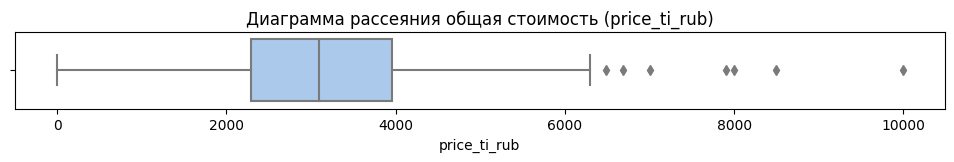

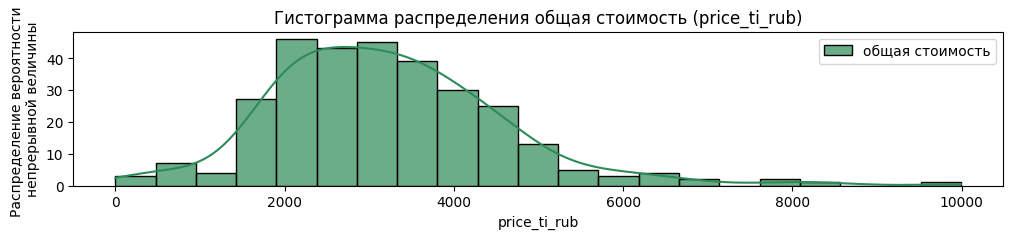

In [17]:
feed_size(data_total, 'price_ti_rub', 'общая стоимость')#, 250

In [18]:
#проверим данные аномальныъ выбросов
data_total[data_total['price_ti_rub']==9990]
data_total[data_total['price_ti_rub']<=400]

,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub
80,Однокомнатная,NaN,Привокзальная 29кв1,1/1,42.5,22.0,12.0,id:5433. \nВ продаже однокомнатная квартира пр...,400.0
52,NaN,NaN,Ленина пр-т 2/2,1/1,45.5,32.0,6.0,id:4863. \nПродам замечательную смежную 2-х ко...,0.0
57,Трехкомнатная,Орджоникидзевский,ул Репина 12,1/1,55.0,39.0,6.0,id:4252. \nВНИМАНИЕ! ЭКСКЛЮЗИВНОЕ ПРЕДЛОЖЕНИЕ ...,0.0


In [19]:
data_total = data_total.query('price_ti_rub != 0')
data_total[data_total['price_ti_rub']==0]

,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub


Статистические данные о распределении значений общая стоимость (price_ti_rub):


count     298.000000
mean     3236.063758
std      1349.811402
min       400.000000
25%      2300.000000
50%      3100.000000
75%      3965.000000
max      9990.000000
Name: price_ti_rub, dtype: float64

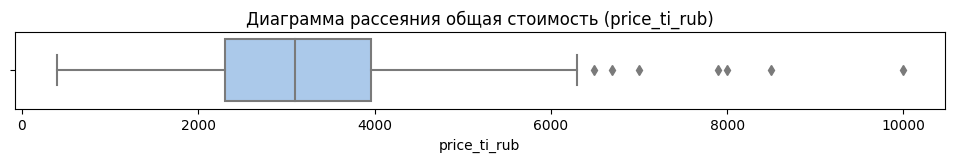

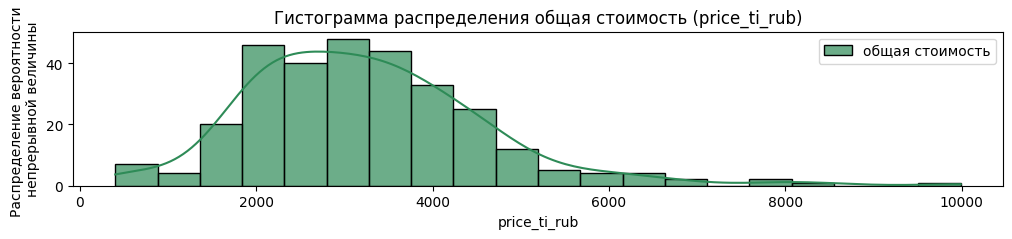

In [20]:
feed_size(data_total, 'price_ti_rub', 'общая стоимость')

Вывод:
- Распределение целевого признака нормальное.
- явный выброс с ценой 0, удаляем данные, так как это главный признак.
- есть также выброс в цене 9999 тыс. руб , но цена здесь общая, а площадь большая у квартиры,
- надо рассчитать относительную цену - за кв.м, и эту относительную цену сделать целевым признаком.

####**Посмотрим на данные общей площади**

Статистические данные о распределении значений общая площадь (s_total_m2):


count    298.000000
mean      52.061342
std       23.067001
min       17.500000
25%       39.000000
50%       49.050000
75%       62.000000
max      304.000000
Name: s_total_m2, dtype: float64

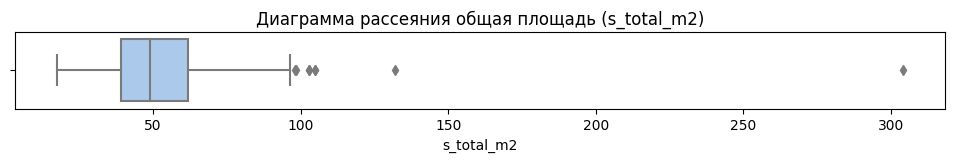

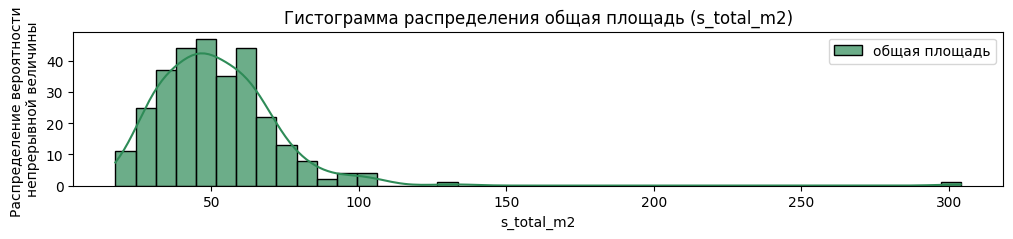

In [21]:
feed_size(data_total, 's_total_m2', 'общая площадь')

In [22]:
data_total[data_total['s_total_m2']==304]

,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub
75,Однокомнатная,NaN,Карла Маркса 64/1,5/5,304.0,17.0,6.0,id:4742. \nПродаётся просторная и уютная однок...,2100.0


In [23]:
data_total = data_total.query('s_total_m2 < 150')
data_total[data_total['s_total_m2']>120]

,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub
40,Трехкомнатная,Орджоникидзевский,Ленина пр-т 135,5/14,132.0,0.0,20.6,"biПредставляю вашему вниманию светлую, уютную ...",9990.0


Вывод:
- В целом распределение данных общей площади нормальное.
- явная аномалия в 304 м2, скорее всего имелось в виду 30,4 м2, удалили ее, так как не играет большую роль.

####**Исследуем данные площади кухни - s_kitchen_m2**

Статистические данные о распределении значений площадь кухни (s_kitchen_m2):


count    297.000000
mean       8.324175
std        3.977218
min        0.000000
25%        6.000000
50%        8.000000
75%        9.000000
max       35.500000
Name: s_kitchen_m2, dtype: float64

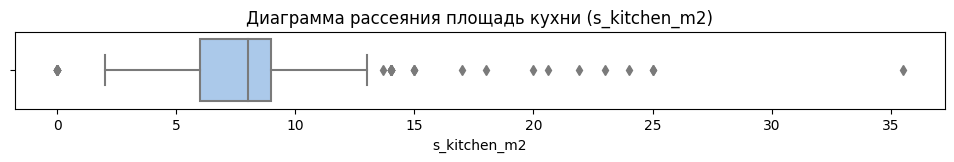

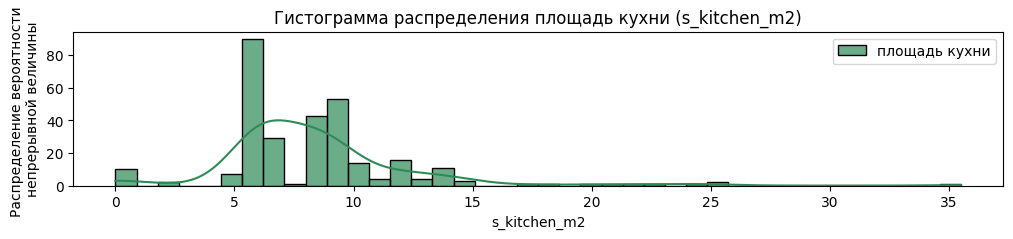

In [24]:
feed_size(data_total, 's_kitchen_m2', 'площадь кухни')

In [25]:
#data = data.query('s_total_m2 < 150')
data_total[data_total['s_kitchen_m2']==0].head()

,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub
78,Однокомнатная,NaN,26 ул. Горнолыжная,1/2,23.0,13.0,0.0,Предлагаем вашему вниманию квартиру в новом жи...,2100.0
8,Однокомнатная,NaN,ул. Курортная 8,3/4,17.5,0.0,0.0,Представляем вашему вниманию уютную студию с р...,2460.0
29,Однокомнатная,Орджоникидзевский,Карла Маркса 227,6/14,38.0,38.0,0.0,Продам однокомнатную квартиру - студию в идеал...,3500.0
37,Однокомнатная,NaN,NaN,1/5,32.9,0.0,0.0,id:4041. \nПродам однокомнатную квартиру с отл...,2000.0
89,Трехкомнатная,NaN,Ленина пр-т 86,9/9,65.2,0.0,0.0,id:4836. \nВ продаже уютная трёхкомнатная квар...,3950.0


Вывод:
- распределение в целом также нормальное.
- наблюдаются явные аномалии в площади кухни = 0, в некоторых случаях - это объяснимо, так как может быть - студия, но в других случаях видимо забыли указать. Оставим как есть, так как таких данных мало и есть данные об общей плащади.

###Обработаем пропуски
`'region'`, `'type_flat'`, `'descr'`, `'descr'`

In [26]:
#data6 = data5[data5.isna().any(axis=1)]
#data6

In [27]:
#функция по обработке данных таблицы
def clean_data1(data):
    data=data.applymap(lambda x: str(x).lower().replace('ё', 'е') if pd.notnull(x) else x)
    mask = (data['descr'].str.contains('рджоникидзевск|енинск|равобережн')) & (data['region'].isna())
    data.loc[mask, 'region'] = data.loc[mask, 'descr'].apply(lambda x: 'орджоникидзевский' if 'рджоникидзевский' in x else \
                                                                   ('ленинский' if 'енинск' in x else 'правобережный'))
    mask1 = (data['descr'].str.contains('однокомнатн|двухкомнатн|трехкомнатн|квартиры-студии')) & (data['type_flat'].isna())
    data.loc[mask1, 'type_flat'] = data.loc[mask1, 'type_flat'].apply(lambda x: 'однокомнатная' if 'однокомнатн' in str(x) else \
                                                            ('двухкомнатная' if 'двухкомнатн' in str(x) else \
                                                             ('однокомнатная студия' if 'квартиры-студии' in str(x) else 'трехкомнатная')))
    return data

In [28]:
data5 = clean_data1(data_total)
research(data5, "данных о квартирах(300 позиций)", figsize=(8, 6), silent=True)

Размер данных:      (297, 9)
Количество явных дубликатов: 0
Наличие пропусков:           79
Пропущенные данные (в процентном соотношении):
region          25.0
adress           1.0
descr            1.0
type_flat        0.0
floor            0.0
s_total_m2       0.0
s_live_m2        0.0
s_kitchen_m2     0.0
price_ti_rub     0.0
dtype: float64


,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub
15,трехкомнатная нестандартная,правобережный,завенягина 14/1,5/5,63.0,42.0,9.0,задаток.продам трехкомнатную нестандартную ква...,3990.0
7,трехкомнатная,ленинский,ленина пр-т 19,2/3,65.0,35.0,9.0,"id:5741. \nв продаже светлая, уютная трехкомна...",4300.0
95,трехкомнатная нестандартная,орджоникидзевский,ленина пр-т 129,5/16,105.0,75.0,14.0,"отличная 3-х комнатная кв-ра, заезжай и живи!!...",7900.0
60,трехкомнатная,ленинский,ленина пр-т 18,2/5,77.0,55.0,11.0,biотличная 3 комнатная квартира в историческом...,4500.0
85,двухкомнатная,правобережный,карла маркса 124,1/9,41.0,0.0,6.0,задаток. в правобережном районе продам двухком...,2350.0


In [29]:
data5['region'].sort_values().unique()

array(['ленинский', 'ленинский (левый берег)', 'орджоникидзевский',
       'орджоникидзевский (левый берег)', 'орджоникидзевский р-н', 'п/б',
       'правоббережный', 'правобережный', 'правобережный район', nan],
      dtype=object)

In [30]:
data5['region'] = data5['region'].str.replace('п/б|правоббережный|правобережный район', 'правобережный', regex=True)
data5['region'] = data5['region'].str.replace('орджоникидзевский р-н', 'орджоникидзевский', regex=True)
data5['region'].sort_values().unique()
data5['region'].value_counts(dropna=False)

орджоникидзевский                  81
NaN                                74
правобережный                      71
ленинский                          66
орджоникидзевский (левый берег)     4
ленинский (левый берег)             1
Name: region, dtype: int64

In [31]:
#на оставшиеся пропущенные значения ставим заглушку
data5['region'] = data5['region'].fillna('unknown')
data5['descr'] = data5['descr'].fillna('unknown')
#data5.dropna (subset=['adress'], inplace=True)
#data5['adress'].isna().sum()
data5['adress'] = data5['adress'].fillna('unknown')
research(data5, "данных о квартирах(300 позиций)", figsize=(8, 6), silent=True)

Размер данных:      (297, 9)
Количество явных дубликатов: 0
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
type_flat       0.0
region          0.0
adress          0.0
floor           0.0
s_total_m2      0.0
s_live_m2       0.0
s_kitchen_m2    0.0
descr           0.0
price_ti_rub    0.0
dtype: float64


,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub
32,четырехкомнатная распашонка,правобережный,карла маркса 138,5/5,62.0,50.0,6.0,продам четырехкомнатную квартиру - распашонка...,3715.0
22,однокомнатная,орджоникидзевский,труда 59/2,3/9,41.0,21.0,9.0,"продам просторную,аккуратную однокомнатную ква...",3250.0
72,однокомнатная брежневка,орджоникидзевский,галиуллина 7/3,5/5,33.0,17.0,6.0,состояние хорошее. косметический ремонт. новый...,2350.0
18,двухкомнатная,правобережный,ленина пр-т 92,11/14,60.8,0.0,9.0,в продаже уютная 2х комнатная квартира сbrрем...,5290.0
94,двухкомнатная старой планировки,ленинский,московская 37,1/3,48.0,33.0,8.0,"продам просторную, светлую, теплую квартиру, о...",2900.0


In [32]:
#data6 = data5[data5.isna().any(axis=1)]
#data6

**Вывод:**
- Поработали с данными в `'region'` и `'type_flat'`, часть значений удалось вытащись из столбца `'descr'` - в результатае количество пропусков удалось снизить `с 32% до 25%`.
- На оставшиеся пропущенные значений поставила заглушку.
- Также проверила значения `'region'` на уникальность - привела к единообразию

### **Формирования датасета для анализа.**

Создадим новые признаки:
- разобъем на 2 столбца - количество этажей(`'total_floor'`) и текущий этаж (`'floor'`)
- этажность (`'floors_category'`): верхний, нижний, другой
- тип квартиры (`type_flat`) - разбиваем на количество комнат (`'room'`) и непосредственно тип (стандартный и другие, которые упоминаются, раздельные комнаты=стандарт)
- стоимость 1 кв метра (`'price_m2'`)
  > `price_m2 = price_ti_rub/s_total_m2 `(измеряется в тыс.руб)
- переведем числовые данные в int и float, категориальные в category типы данных, для более удобных расчетов в посроении моделей

#### Создадим функцию для формирования новых признаков: **'type_flat'** и **'room'**, **'total_floor'** и **'floor'**


In [33]:
#data5['type_flat'].value_counts(dropna=False)
#data5['floor'].sort_values().unique()
#data5.loc[35]

In [34]:
#функция формирующая датасет и генерирующая новые признаки
def create_futures(data):
    #создаем новый признак - количество комнат 'room'
    mask = (data['type_flat'].str.contains('однокомнатная|двухкомнатная|трехкомнатная|четырехкомнатная|многокомнатная'))
    data.loc[mask, 'room'] = data.loc[mask, 'type_flat'].apply(lambda x: '1' if 'однокомнатная' in x else \
                                                              ('2' if 'двухкомнатная' in x else\
                                                              ('3' if 'трехкомнатная' in x else \
                                                              ('4' if 'четырехкомнатная' in x else '5'))))
    # стантартизируем признак типа квартиры
    mask1 = (data['descr'].str.contains('3-ая')) & (data['type_flat']=='многокомнатная')
    data.loc[mask1, 'type_flat'] = data.loc[mask1, 'type_flat'].str.replace(r'многокомнатная',\
                                                      'трехкомнатная', regex=True)
    data['type_flat'] = data['type_flat'].str.replace(r'(однокомнатная |двухкомнатная |трехкомнатная |четырехкомнатная )',\
                                                      '', regex=True)
    data['type_flat'] = data['type_flat'].str.replace(r'(однокомнатная|двухкомнатная|трехкомнатная|четырехкомнатная|многокомнатная|раздельная)',\
                                                      'стандартная', regex=True)

    #создаем новые признаки - общее количество этажей('total_floor') и текущий этаж ('floor')
    data[['floor', 'total_floor']] = data['floor'].str.split('/', expand=True).astype(int)

    #создаем категориальный признак по типам этажа квартиры (значения — «первый», «последний», «другой»)
    data5['floors_category'] = data5.apply(lambda row: 'первый' if row['floor'] == 1 \
                                       else 'последний' if row['floor'] == row['total_floor'] \
                                       else 'другой', axis=1)

    return data

In [35]:
data5 = create_futures(data5)
express_info(data5, 'общего датасета')

Информация общего датасета:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 1 to 102
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   type_flat        297 non-null    object
 1   region           297 non-null    object
 2   adress           297 non-null    object
 3   floor            297 non-null    int64 
 4   s_total_m2       297 non-null    object
 5   s_live_m2        297 non-null    object
 6   s_kitchen_m2     297 non-null    object
 7   descr            297 non-null    object
 8   price_ti_rub     297 non-null    object
 9   room             297 non-null    object
 10  total_floor      297 non-null    int64 
 11  floors_category  297 non-null    object
dtypes: int64(2), object(10)
memory usage: 38.3+ KB


,type_flat,region,adress,floor,s_total_m2,s_live_m2,s_kitchen_m2,descr,price_ti_rub,room,total_floor,floors_category
1,свердловский вариант,орджоникидзевский,калмыкова 12,9,64.0,40.0,10.0,описание\n квартира с отличным капитальным рем...,4390.0,3,9,последний
2,брежневка,ленинский,тарасенко 6,5,45.0,29.0,6.0,продам двухкомнатную квартиру в среднем состоя...,1800.0,2,5,последний
4,стандартная,unknown,грязнова 17,3,32.0,19.0,6.0,id:5068. \n!! продам однокомнатную квартиру в ...,2050.0,1,5,другой


In [36]:
#Функция - выводит статистистику категориальных признаков
def plotbar_top5(data, index, title):
    pdv = pd.DataFrame(data.pivot_table(index=index, aggfunc='size').sort_values(ascending=False)).head(5)
    pdv.columns = ['count']
    plt.figure(figsize=(10,3))
    plt.title(title)
    sns.barplot(x='count', palette='pastel',  y=pdv.index, data=pdv)

#### Переведем числовые данные в int и float для более удобных расчетов в посроении моделей

In [40]:
#для дальнейшего удобства расчетов поменяем формат числовых данных
data5['price_ti_rub'] = pd.to_numeric(data5['price_ti_rub'], errors='coerce').round().astype('int16')
data5['room'] = pd.to_numeric(data5['room'], errors='coerce').round().astype('int16')
data5['s_total_m2'] = pd.to_numeric(data5['s_total_m2'], errors='coerce').round().astype('float64')
data5['s_live_m2'] = pd.to_numeric(data5['s_live_m2'], errors='coerce').round().astype('float64')
data5['s_kitchen_m2'] = pd.to_numeric(data5['s_kitchen_m2'], errors='coerce').round().astype('float64')

## **4. Анализ данных и подготовка для построения математической модели.**


###**Генерация целевого признака.**

#### Создаем новый признак - стоимость 1 кв метра (`'price_m2'`)
  > `price_m2 = price_ti_rub/s_total_m2` (измеряется тыс. в руб)

In [41]:
# рассчитаем цену одного квадратного метра и создадим столбец price_1sm в тыс. руб.
data5['price_m2'] = data5['price_ti_rub']/ data5['s_total_m2']
data5['price_m2'] = pd.to_numeric(data5['price_m2'], errors='coerce').round().astype('int64')
#выведем среднюю стоимость по регионам
data_average=data5.pivot_table(index='region',  values='price_m2', aggfunc='median')
data_average = data_average.reset_index()
# Проверяем
data_average.sort_values('price_m2').tail(7)

,region,price_m2
2,ленинский (левый берег),30.0
4,орджоникидзевский (левый берег),37.5
1,ленинский,62.0
5,правобережный,64.0
0,unknown,64.5
3,орджоникидзевский,69.0


Статистические данные о распределении значений стоимость 1 кв.м (price_m2):


count    297.000000
mean      63.713805
std       14.793017
min        8.000000
25%       58.000000
50%       64.000000
75%       71.000000
max      137.000000
Name: price_m2, dtype: float64

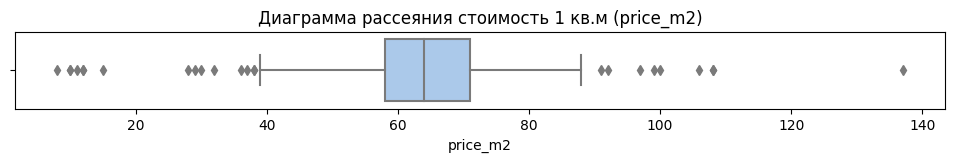

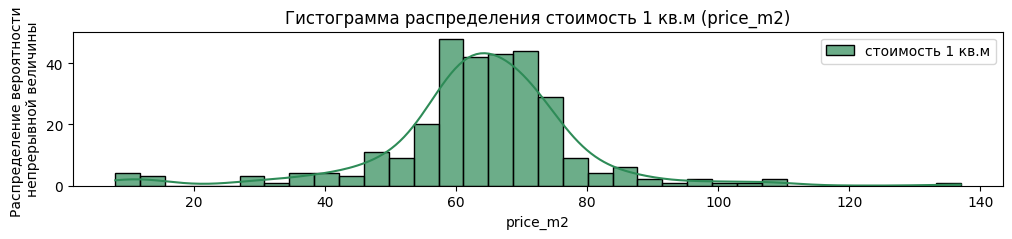

In [42]:
feed_size(data5, 'price_m2', 'стоимость 1 кв.м')

**Вывод:**
- У нового пизнака `price_m2` распределение нормальное
- По предварительной оценке - мы видим, что самая большая средняя стоимость жилья в **Орджоникидзевском районе**.
- В Ленинском и Правобережных районах - стоимость жилья приблизительно одинаковая,
- самая низкая стоимость квартир в районах на левом берегу.

В дальнейшем можем использовать данную информацию.

### **Анализ получившегося датасета.**

In [43]:
#напишем функию для исследования данных
def research1(data, name, figsize, silent):
    print(f'Размер данных:      {data.shape}')
    if silent:
        data.columns
    if not silent:
        print(f'Количество явных дубликатов: {data.duplicated().sum()}')
        print(f'Наличие пропусков:           {data.isna().sum().sum()}')
        data.info()

    if silent:
        data.columns
    #тепловая карта корреляций
    phik_overview = data.phik_matrix()
    plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Pastel2", #Greens
                        title=f"Корреляция {name} $\phi_K$", #r"Корреляция {name} $\phi_K$"
                        fontsize_factor=1,
                        figsize=(12, 7))
    plt.tight_layout()
    if not silent:
        #print(f'\nПроверка структуры {name}:')
        data.hist(linewidth=2, histtype='step', figsize=figsize) #
        plt.suptitle(f'Гистограмма распеределения {name}', y=0.94, fontsize=12)
        plt.show()
        print()
        display(data.sample(3))
        display(data.describe())

Размер данных:      (297, 13)
interval columns not set, guessing: ['floor', 's_total_m2', 's_live_m2', 's_kitchen_m2', 'price_ti_rub', 'room', 'total_floor', 'price_m2']


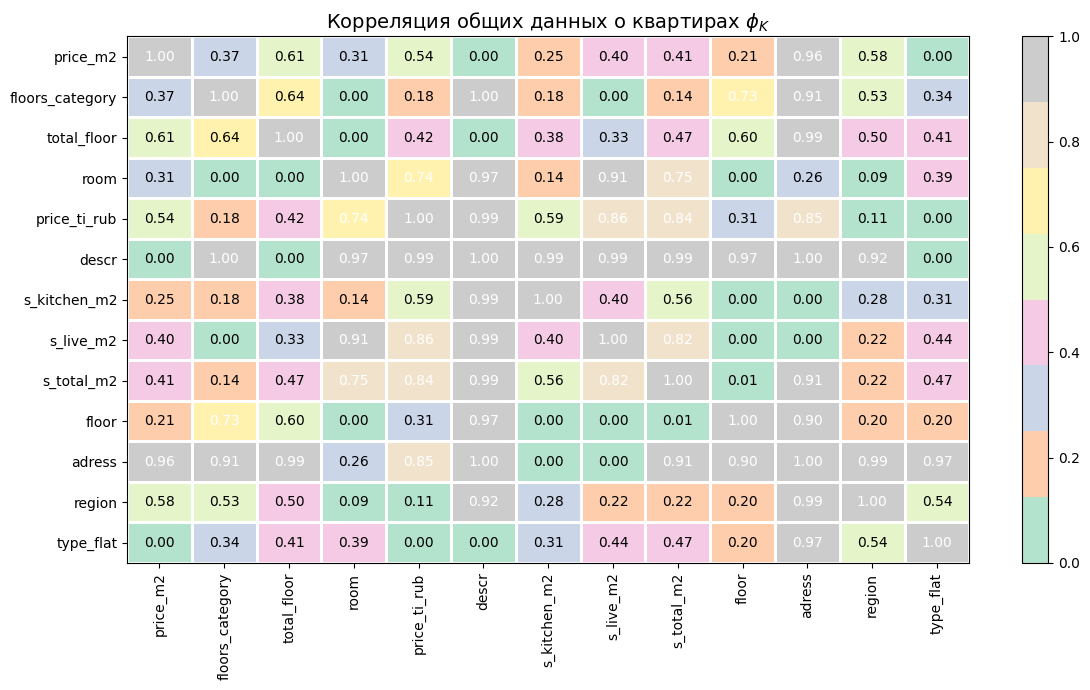

In [44]:
research1(data5, 'общих данных о квартирах', figsize=(12,7), silent=True)

### **Удаление неинформативных признаков**

In [45]:
#удаляем данные с высокой корреляцией
data5 = data5.drop([ 'descr', 'adress', 's_live_m2','price_ti_rub'], axis=1)
data5.columns

Index(['type_flat', 'region', 'floor', 's_total_m2', 's_kitchen_m2', 'room',
       'total_floor', 'floors_category', 'price_m2'],
      dtype='object')

Размер данных:      (297, 9)
Количество явных дубликатов: 0
Наличие пропусков:           0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 1 to 102
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type_flat        297 non-null    object 
 1   region           297 non-null    object 
 2   floor            297 non-null    int64  
 3   s_total_m2       297 non-null    float64
 4   s_kitchen_m2     297 non-null    float64
 5   room             297 non-null    int16  
 6   total_floor      297 non-null    int64  
 7   floors_category  297 non-null    object 
 8   price_m2         297 non-null    int64  
dtypes: float64(2), int16(1), int64(3), object(3)
memory usage: 29.6+ KB
interval columns not set, guessing: ['floor', 's_total_m2', 's_kitchen_m2', 'room', 'total_floor', 'price_m2']


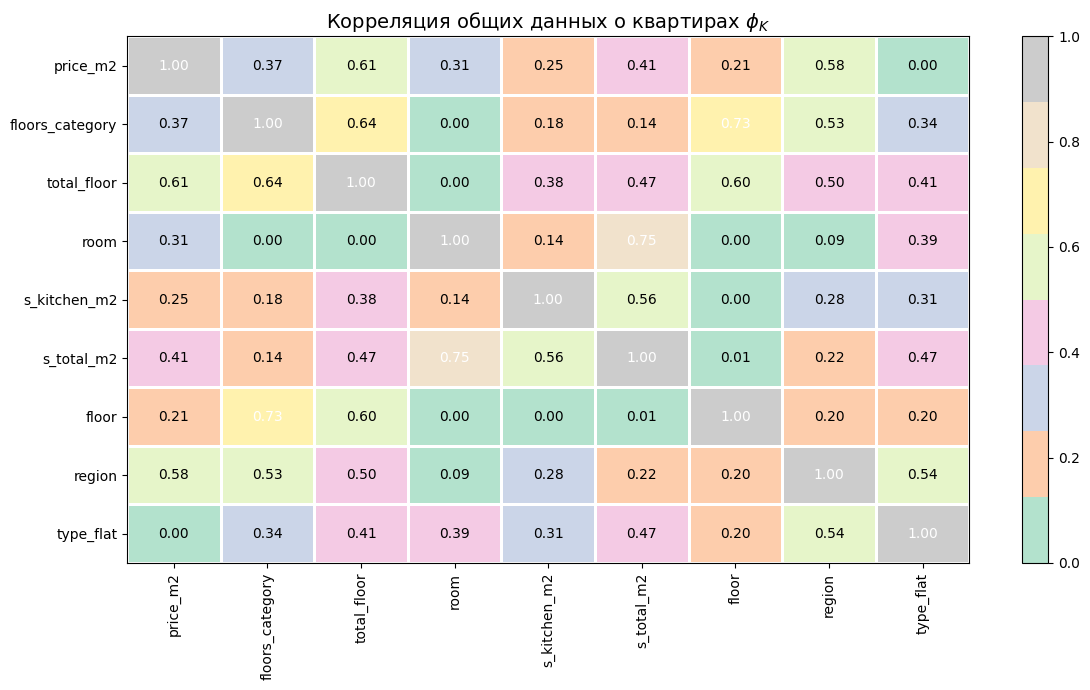

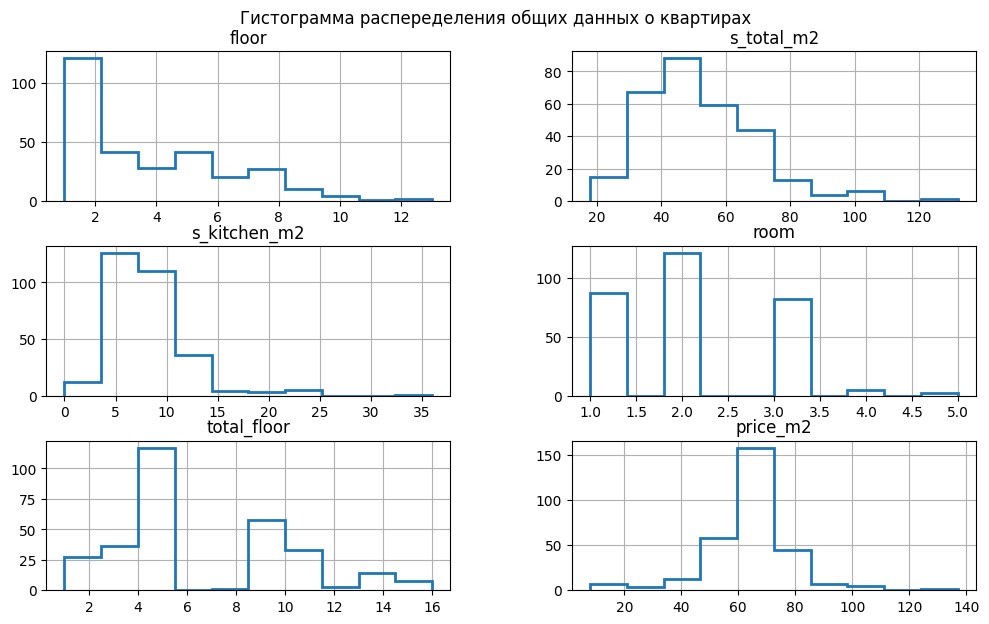

,type_flat,region,floor,s_total_m2,s_kitchen_m2,room,total_floor,floors_category,price_m2
68,стандартная,unknown,4,61.0,7.0,4,5,другой,66
56,стандартная,unknown,1,43.0,7.0,2,5,первый,70
94,малосемейка,правобережный,6,22.0,6.0,1,9,другой,70


,floor,s_total_m2,s_kitchen_m2,room,total_floor,price_m2
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,3.740741,51.208754,8.326599,2.037037,6.538721,63.713805
std,2.491226,17.850832,3.995487,0.835433,3.570622,14.793017
min,1.000000,18.000000,0.000000,1.000000,1.000000,8.000000
25%,2.000000,39.000000,6.000000,1.000000,4.000000,58.000000
50%,3.000000,49.000000,8.000000,2.000000,5.000000,64.000000
75%,5.000000,62.000000,9.000000,3.000000,9.000000,71.000000
max,13.000000,132.000000,36.000000,5.000000,16.000000,137.000000


In [46]:
research1(data5, 'общих данных о квартирах', figsize=(12,7), silent=False)

**Выводы:**

- Аналитика показывает, что у нас `'descr'`, `'adress'` сильно коррелируютт со всеми признаками данные - удалили их.
- причем идет ссильная корреляция (phik= 0.91) между количеством комнат (`room`) и жилой площадью (`s_live_m2`), что в принципе логично - удалим жилую площадь (`s_live_m2`) и (`price_ti_rub`).
- Корреляция между общей стоимостью жилья и стоимостью 1кв м - 0.53, в принципе хорошая, но не настолько, чтобы ее удалять один из признаков - посмотрим, как поведут себя модели при расчетах.

###**Переведем категориальные типы данных в `category`, для более удобных расчетов в посроении моделей**

In [47]:
#переведем категориальные данные в category типы данных, для более удобных расчетов в посроении моделей
data5['type_flat'] = data5['type_flat'].astype('category')
data5['region'] = data5['region'].astype('category')
data5['floors_category'] = data5['floors_category'].astype('category')
data5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 1 to 102
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   type_flat        297 non-null    category
 1   region           297 non-null    category
 2   floor            297 non-null    int64   
 3   s_total_m2       297 non-null    float64 
 4   s_kitchen_m2     297 non-null    float64 
 5   room             297 non-null    int16   
 6   total_floor      297 non-null    int64   
 7   floors_category  297 non-null    category
 8   price_m2         297 non-null    int64   
dtypes: category(3), float64(2), int16(1), int64(3)
memory usage: 24.5 KB


#### **Выводы:**
- Ввела новые признаки:
   - числовые: количество этажей(`'total_floor'`), текущий этаж (`'floor'`), количество комнат (`'room'`), стоимость 1 кв метра (`'price_m2'`),
   - категориальные: тип квартиры (`type_flat`), этажность (`'floors_category'`) - верхний, нижний, другой.
- удалила сильно коррелирующие между собой признауки `'descr'`, `'adress'`, `s_live_m2`,`price_ti_rub`.
- Корреляция между общей стоимостью жилья и стоимостью 1кв м - 0.53, в принципе хорошая, но не настолько, чтобы ее удалять один из признаков - посмотрим, как поведут себя модели при расчетах.
- стоимость 1 кв метра в тыс.руб. (`'price_m2'`) - определяем целевым признаком.

### **Разделение общего датасета на выборки для обучения и проверки модели.**

In [48]:
#входящие данные
random_state = 12345
cv_counts = 5
features = data5.drop('price_m2', axis=1)
target = data5['price_m2']

Данных мало, поэтому использую подход разбики данные на тренировочные и тестовые в масштабе 1:4
> будем подбирать параметры с помощью gridsearch, randomsearch

In [49]:
features_train, features_test, target_train, target_test = train_test_split(
                                                            features, target,
                                                            test_size=0.25, random_state=random_state)
#Проверим размеры выборок:
for i in [features_train, target_train, features_test, target_test]:
    print(i.shape)

(222, 8)
(222,)
(75, 8)
(75,)


### **Кодирование и масштабирование признаков - стандартизация данных, по необходимости.**

Так как у нас присутствуют категориальные признаки, применим методы OE и OHE для кодирования.

Так как у нас разные модели, то используем разные методы кодирования.
Для линейной модели используем метод прямого кодирования ОНЕ

In [50]:
#категориальные признаки
cat_features = features_train.select_dtypes(include='category').columns.to_list()
print(cat_features)
#численные признаки
num_features = features_train.select_dtypes(exclude='category').columns.to_list()
num_features

['type_flat', 'region', 'floors_category']


['floor', 's_total_m2', 's_kitchen_m2', 'room', 'total_floor']

In [51]:
#для модели нели нелинейных моделей, в частности GBMRegressor
#Преобразуем категориальные признаки в численные с помощью техники порядкового кодирования OE
encoder = OrdinalEncoder( dtype=np.int16)
features_train_oe = features_train[cat_features]
encoder.fit(features_train[cat_features])
features_train_oe[cat_features] = encoder.transform(features_train[cat_features]).astype(np.int16)

features_test_oe = features_test[cat_features]
encoder.fit(features_test[cat_features])
print('Закодированные методом OE данные')
display(features_train_oe.head(3))
display(features_test_oe.head(3))

Закодированные методом OE данные


,type_flat,region,floors_category
68,9,0,0
82,9,1,2
17,0,5,2


,type_flat,region,floors_category
67,стандартная,правобережный,другой
88,стандартная,unknown,другой
36,стандартная,unknown,последний


In [52]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()
#запускаем энкодер и обучаем выборки
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train_ohe[cat_features])
features_train_ohe[encoder_ohe.get_feature_names_out()] = \
                        encoder_ohe.transform(features_train_ohe[cat_features])
features_train_ohe = features_train.drop(cat_features, axis=1)

features_test_ohe[encoder_ohe.get_feature_names_out()] = \
                        encoder_ohe.transform(features_test_ohe[cat_features])
features_test_ohe = features_test.drop(cat_features, axis=1)
print('Закодированные методом OHE данные')
display(features_train_ohe.head(2))
display(features_test_ohe.head(2))

# стандартизируем данные ohe
features_train_ohe_sc = features_train_ohe.copy()
features_test_ohe_sc = features_test_ohe.copy()
scaler = StandardScaler()
features_train_ohe_sc[num_features] = scaler.fit_transform(features_train[num_features]) #train
features_test_ohe_sc[num_features] = scaler.transform(features_test_ohe_sc[num_features])#тестовую
print('Закодированные методом OHE стандартизированные данные')
display(features_train_ohe_sc.head(2))
display(features_test_ohe_sc.head(2))

Закодированные методом OHE данные


,floor,s_total_m2,s_kitchen_m2,room,total_floor
68,4,53.0,9.0,2,9
82,4,60.0,0.0,3,4


,floor,s_total_m2,s_kitchen_m2,room,total_floor
67,2,44.0,6.0,2,5
88,3,44.0,8.0,2,5


Закодированные методом OHE стандартизированные данные


,floor,s_total_m2,s_kitchen_m2,room,total_floor
68,0.122913,0.081318,0.214974,-0.072648,0.719422
82,0.122913,0.473767,-2.171239,1.167962,-0.666965


,floor,s_total_m2,s_kitchen_m2,room,total_floor
67,-0.668004,-0.423259,-0.580430,-0.072648,-0.389687
88,-0.272545,-0.423259,-0.050161,-0.072648,-0.389687


#### **Вывод:**
- Данных мало, поэтому разбила данные на тренировочные и тестовые в масштабе 1:4
> буду подбирать параметры с помощью gridsearch, randomsearch
- Применила методы кодирования OE, OHE и стандартизации для формирования признаков, буду тестить линейные и нелинейные модели.
- Буду тестить модели с применением этих двух наборов данных.

## **5. Обучение моделей¶**

### **Описание моделей:**

У нас задача регресии, начит будем рассматривать линейные и нелинейные модели регресии.

- **Линейные модели**:
  - Линейная регрессия:
  > разновидность регрессии для моделирования линейной зависимости между зависимой и независимой переменными.
  - Ridge:
  > это линейная модель наименьших квадратов с регуляризацией l2. Другими словами, это линейная регрессия с регуляризатором l2.
Чрезмерная или недостаточная подгонка модели Ridge зависит от параметра alpha, который можно настроить на правильное значение, выполнив настройку гиперпараметров, что мы и будем делать далее.

Так как у нас есть признаки, которые сильно коррелируют между собой (я не удалила базовую стоимость), поэтому чтобы избежать мультиколлинеарности используем линейную регресию **Ridge**.
Проведем кроссвалидацию и подтвердим, либо опровергнем мою гипотезу.

- **Нелинейные модели, работающие по алгоритму градиентного бустинга**:
  - CatBoostRegressor,
  > CatBoost – это библиотека градиентного бустинга, которую создали разработчики Яндекса. Здесь используются “забывчивые” (oblivious) деревья решений, при помощи которых мы растим сбалансированное дерево. Одни и те же функции используются для создания разделений (split) на каждом уровне дерева.
  - XGBRegressor
  > более регуляризованная форма градиентного бустинга. Основным преимуществом данной библиотеки является производительность и эффективная оптимизация вычислений (лучший результат с меньшей затратой ресурсов).

Будем использовать **pipeline** вместе с кросс-валидацией ( методами **GridSearchCV** и **RandomSearchCV**). Это позволит кодировать и масштабировать отдельно каждую тренировочную и валидационную выборки внутри кросс-валидации (без «подглядывания»).



### **Проведем предвартельную проверку моделей**

In [53]:
from sklearn.ensemble import RandomForestRegressor
models = []
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('CatBoostR', CatBoostRegressor(random_state = random_state, verbose=False)))
#models.append(('LGBMR', LGBMRegressor(random_state = random_state)))
models.append(('XGBR', XGBRegressor(random_state = random_state)))

def cvs (models, features_train, target_train):

    # запускаем расчет моделей в цикле
    results = []
    names = []
    for name, model in models:
        cv_mae = (cross_val_score(model,features_train,
                                 target_train, cv=5,
                                 scoring='neg_mean_absolute_error').mean() * -1)
        results.append(cv_mae)
        names.append(name)
        print('MAE %s:  %f ' % (name, cv_mae.mean()))#(%f), cv_mae.std()
        print('RMSE %s:  %f ' % (name, abs(cv_mae.mean())** 0.5))

    return results, results

In [54]:
#Закодированные методом ОНЕ
#results_ohe, names_ohe = cvs (models, features_train_ohe, target_train)

In [55]:
#Закодированные методом ОНЕ и стандартезированные
results_ohe_sc, names_ohe_sc = cvs (models, features_train_ohe_sc, target_train)
#print(results_ohe)

MAE LR:  10.001144 
RMSE LR:  3.162459 
MAE Ridge:  9.992004 
RMSE Ridge:  3.161013 
MAE CatBoostR:  11.009763 
RMSE CatBoostR:  3.318096 
MAE XGBR:  12.497834 
RMSE XGBR:  3.535228 


In [56]:
#Закодированные методом ОЕ
results_oe, names_oe = cvs (models, features_train_oe, target_train)

MAE LR:  10.142293 
RMSE LR:  3.184697 
MAE Ridge:  10.138923 
RMSE Ridge:  3.184168 
MAE CatBoostR:  10.516632 
RMSE CatBoostR:  3.242936 
MAE XGBR:  10.634511 
RMSE XGBR:  3.261060 


**Вывод:**
- Проверка кросс-валидации показала, что OHE нестандартизированные данные - работают не со всеми моделями, Xто и понятно.
- Лучше всего себя показала модель:
  - линейные в принципе, из них **Ridge**:
    - MAE Ridge:  9.99
    - RMSE Ridge:  3.16
  - бустинговая **CatBoostR**:
    - MAE CatBoostR:  10.52
    - RMSE CatBoostR:  3.24.
- Все же лучший результат дают закодированные OHE и стандартизированные данные линейных моделей, Ridge. поэтому будем работать с ними.

Приступим непосредственно к обучению:
- уберем модели, котрые дали результат хуже, оставим 3 шт., чтобы не перегружать проект.
- используем **pipeline**, перебор методами **GridSearchCV** и **RandomSearchCV**

In [57]:
# Вводим переменные
model_2 = Ridge()
model_3 = CatBoostRegressor(random_state = random_state, verbose=False)
model_5 = XGBRegressor(random_state = random_state)

In [58]:
%%time
# Инициируем гиперпараметры для рассматриваемых моделях
param2 = {}
param2['regression__alpha'] = np.arange(0, 0.21, 0.01)
param2['regression'] = [model_2]

param3 = {}
param3['regression__learning_rate'] = [i/10 for i in range(1, 6)]
param3['regression__n_estimators'] = [50, 100, 10]
param3['regression__loss_function'] = ['MAE']
param3['regression__max_depth'] = [i for i in range(5,10)]
param3['regression__class_weight'] = [None, 'balanced']
param3['regression'] = [model_3]

param5 = {}
param5['regression__learning_rate'] = [i/100 for i in range(1, 50)]
#param5['regression__silent'] = [True]
param5['regression'] = [model_5]

CPU times: user 48 µs, sys: 7 µs, total: 55 µs
Wall time: 60.1 µs


In [59]:
%%time
pipeline = Pipeline([('regression', model_2)])
params = [param2, param3, param5] #param1,, param4

CPU times: user 17 µs, sys: 3 µs, total: 20 µs
Wall time: 22.4 µs


### **GridSearchCV**

In [60]:
%%time
start = time.time()
gs = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error').fit(features_train_ohe_sc, target_train)
end = time.time()
t_gs=round(end-start,2)

CPU times: user 1.13 s, sys: 53.2 ms, total: 1.19 s
Wall time: 24.9 s


In [61]:
# Гиперпараметры лучшей модели на GridSearchCV
gs.best_params_

{'regression': Ridge(alpha=0.2), 'regression__alpha': 0.2}

In [62]:
# MAE для лучшей модели
mae_gs = gs.best_score_
print(f'Абсолютное среднее отклонение лучшей модели, найденной методом GridSCV MAE_train = {round(mae_gs.mean() * -1, 2)}')
print('Среднеквадратичная ошибка лучшей модели, \
найденной методом GridSCV RMSE = {:.2f}'.format((-gs.best_score_) ** 0.5))

Абсолютное среднее отклонение лучшей модели, найденной методом GridSCV MAE_train = 10.0
Среднеквадратичная ошибка лучшей модели, найденной методом GridSCV RMSE = 3.16


### **Randomized Search CV**

In [63]:
%%time
start = time.time()
rs = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error').fit(features_train_ohe_sc, target_train)
end = time.time()
t_rs=round(end-start,2)

CPU times: user 105 ms, sys: 2.84 ms, total: 108 ms
Wall time: 1.11 s


In [64]:
# Гиперпараметры лучшей модели на RandomizedSearchCV
rs.best_params_

{'regression__alpha': 0.17, 'regression': Ridge(alpha=0.17)}

In [65]:
# MAE для лучшей модели
mae_rs = rs.best_score_
print(f'Абсолютное среднее отклонение лучшей модели, \
найденной методом RandomSCV MAE_train = {round(mae_rs.mean() * -1, 2)}')
print('Среднеквадратичная ошибка лучшей модели, \
найденной методом RandomSCV RMSE = {:.2f}'.format((-rs.best_score_) ** 0.5))

Абсолютное среднее отклонение лучшей модели, найденной методом RandomSCV MAE_train = 10.0
Среднеквадратичная ошибка лучшей модели, найденной методом RandomSCV RMSE = 3.16


Как показывает исследование **GridSearchCV** считает медленнее, чем **RandomSCV**, но показывает лучшие результаты RMSE

## 6. **Проверка лучшей модели на тестовой выборке.**

In [66]:
mae_test_gs = mean_absolute_error(gs.predict(features_test_ohe_sc), target_test)

if mae_test_gs > 0:
    rmse_test_gs = np.sqrt(mae_test_gs)
    print(f'Абсолютное среднее отклонение лучшей модели, найденной методом GridSearchCV MAE_test = {round(mae_test_gs, 2)}')
    print(f'Среднеквадратичная ошибка лучшей модели, найденной методом GridSearchCV RMSE_test = {round(rmse_test_gs, 2)}')

Абсолютное среднее отклонение лучшей модели, найденной методом GridSearchCV MAE_test = 8.57
Среднеквадратичная ошибка лучшей модели, найденной методом GridSearchCV RMSE_test = 2.93


### **Исследование значимости признаков лучшей модели**

In [67]:
start = time.time()
# gs_importances = gs.fit(features_test_ohe_sc, target_train)
if isinstance(gs.best_estimator_._final_estimator, LinearRegression):
    feature_importances_gs = np.abs(gs.best_estimator_._final_estimator.coef_)
elif isinstance(gs.best_estimator_._final_estimator, Ridge):
    feature_importances_gs = np.abs(gs.best_estimator_._final_estimator.coef_)
else:
    feature_importances_gs = gs.best_estimator_._final_estimator.feature_importances_
end = time.time()
t_rs = round(end - start, 2)

In [68]:
def graph_features (model, features, name):
    feature_importance = pd.DataFrame((model), list(features.columns),columns=['Значения'])\
                                        .reset_index().rename(columns={'index':'Признаки'})
    plt.figure(figsize=(10, 3))
    sns.barplot(x="Значения", y="Признаки", data=feature_importance.sort_values(by="Значения", ascending=False), palette = 'tab20')#'Pastel2','rainbow'
    plt.title(f'Оценка важности признаков {name}')
    plt.tight_layout()
    plt.show()

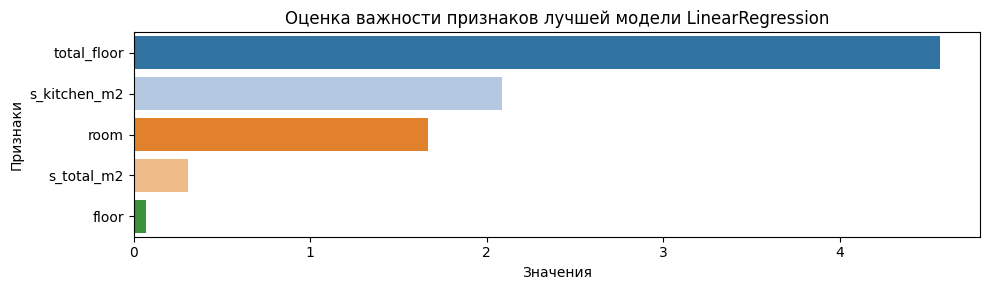

In [69]:
graph_features (feature_importances_gs, features_test_ohe_sc, 'лучшей модели LinearRegression')

# **Предсказываем цены квартиры с помощью нашей модели:**

Напишем функцию, которая принимает параметры квартиры в качестве аргументов и возвращает предсказанную цену квартиры.


In [70]:
def predict_price(floor, s_total_m2, s_kitchen_m2, room, total_floor):
    # Создание массива с параметрами квартиры
    features = [[floor, s_total_m2, s_kitchen_m2, room, total_floor]]
    # Выполнение предсказания с использованием обученной модели gs
    predicted_price = gs.predict(features)

    return predicted_price[0]


In [71]:
#скидываем индексы и присваиваем их попорядку
data5 = data5.reset_index(drop=True)

Зпускаем модель: берем данные квартиры с индекссами 10, 18,.

In [72]:
predicted_price = predict_price(data5['floor'][10], data5['s_total_m2'][10], data5['s_kitchen_m2'][10], \
                                data5['room'][10], data5['total_floor'][10])
predicted_price

86.73458907267255

In [73]:
predicted_price = predict_price(data5['floor'][18], data5['s_total_m2'][18], data5['s_kitchen_m2'][18], \
                                data5['room'][18], data5['total_floor'][18])
predicted_price

71.49205093880552

In [74]:
predicted_price = predict_price(data5['floor'][66], data5['s_total_m2'][66], data5['s_kitchen_m2'][66], \
                                data5['room'][66], data5['total_floor'][66])
predicted_price

72.16453630986626

In [75]:
#проверяем наше предсказание
data5.loc[10],data5.loc[18],data5.loc[66]

(type_flat            стандартная
 region             правобережный
 floor                          2
 s_total_m2                  31.0
 s_kitchen_m2                 6.0
 room                           1
 total_floor                    5
 floors_category           другой
 price_m2                      82
 Name: 10, dtype: object,
 type_flat                стандартная
 region             орджоникидзевский
 floor                              3
 s_total_m2                      74.0
 s_kitchen_m2                    11.0
 room                               3
 total_floor                        3
 floors_category            последний
 price_m2                          70
 Name: 18, dtype: object,
 type_flat          индивидуальный проект
 region                 орджоникидзевский
 floor                                  2
 s_total_m2                          57.0
 s_kitchen_m2                         8.0
 room                                   2
 total_floor                            3
 floor

Проверили предсказание

### **Выводы:**
В проекте была проеизведена следующая работа:

- Источник исходных данных www.citystar.ru - сайт магнитогорской недвижимости. **Парсила** данные с помощью Web Scraper. В итоге были получены 3 файла с данными.
- Загрузила данные, изучила - сразу произвела чистку данных от явно ненужных значений, символов и ненужных ссылок. Соединила в единый документ.
- Проверила данные на наличие пропусков и дубликатов, аномалий:
   - Пропущенные данные в основном в в **region**- 32%
   - дубликатов не обнаружила;
   - явный выброс был 1 - удалила.
- Провела обработку данных:
   - в результате пропущенные значения в region снизились до 25%.
   - на остальные пропуски поставила заглушки.
   - проверила значения 'region' на уникальность - привела к единообразию.
- поработала с данными по столбцам, разделила данные. В итоге плучила новые признаки:
   - числовые: количество этажей(`'total_floor'`), текущий этаж (`'floor'`), количество комнат (`'room'`), стоимость 1 кв метра (`'price_m2'`),
   - категориальные: тип квартиры (`type_flat`), этажность (`'floors_category'`) - верхний, нижний, другой.
- Сгенерировала новый признак - стоимость 1 кв метра (`'price_m2'`)
- Проанализировала корреляцию получившихся признаков, удалила наиболее коррелирующие и неинформативные для нас.
- В итоге получила датасет с числовыми и категориальными признаками.
- Приступила непосредственно к подготовке данных к обучению:
  - разбила данные на тренировочные и тестовые в масштабе 1:4
  - Применила методы кодирования OE, OHE и стандартизации для формирования признаков.
- Провела обучение моделей: У нас задача регрессии.
 - Для обучения выбрала набор линейных моделей (Линейная регрессия,
Ridge) и моделий работающих по алгоритму бустинга (LightGBMRegressor,
CatBoostRegressor, XGBRegressor.)
 - Качество модели проверяла метриками MAE и RMSE (именно они лучше всего подходят при работе с бустинговыми моделями).
 - Предварительно поверила модели с применением этих двух наборов данных - выбрала набор данных с лучшим результатом - OHE+Scaller.
 - В итоге из линейных моделей лучше всего себя показала **Ridge**:
      - `MAE Ridge`: 9.99
      - `RMSE Ridge`: 3.16;
  - бустинговая **CatBoostR**:
    - MAE CatBoostR:  10.52
    - RMSE CatBoostR:  3.24.
  > В итоге на обучение отправила линейнуд модель Ridge и 2 бустинговых модели LGBM и CatBoostR данные при применении **GridSearchCV**.
 - В результате к качестве тестовой модели была выбрана линейная **модель Ridge** с параметрами `Ridge(alpha=0.2)`:
     - `MAE_test` = 8.57
     - `RMSE_test` = 2.93

- Провела оценку наиболее значимых признаков. В нашей задаче - это оказались: этажность самого дома и площадь кухни.

- проверила работу модели на 3х квартирах:
  1) type_flat-стандартная, region-правобережный, s_total_m2 - 31.0
 s_kitchen_m2 - 6.0, room -1, total_floor - 5 , price_m2 - 82 тыс.руб.
  > предсказание модели - 86.73 тыс.руб.
  
  2) type_flat - стандартная, region - орджоникидзевский, room -3, price_m2 - 7 тыс.руб;
  > предсказание модели - 71.49 тыс.руб.
  
  3) type_flat - индивидуальный проект, region - орджоникидзевский,
   room -2,price_m2 - 70 тыс.руб;
  > предсказание модели - 72.16 тыс.руб.

## **Загрузим данные в базу данных.**
 > Модель должна иметь REST API. На вход модели подаются параметры квартиры в формате JSON на выходе получается цена квартиры в формате JSON.


In [76]:
import json
from flask import Flask, request
!pip install flask

app = Flask(__name__)

# Load the model and make predictions
def predict_price(floor, s_total_m2, s_kitchen_m2, room, total_floor):
    features = [[floor, s_total_m2, s_kitchen_m2, room, total_floor]]
    predicted_price = gs.predict(features)

    return predicted_price[0]

# Route for getting predictions
@app.route('/predict', methods=['POST'])
def get_prediction():
    data = request.get_json()
    floor = data['floor']
    s_total_m2 = data['s_total_m2']
    s_kitchen_m2 = data['s_kitchen_m2']
    room = data['room']
    total_floor = data['total_floor']
    result = predict_price(floor, s_total_m2, s_kitchen_m2, room, total_floor)
    return json.dumps(result)

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
